<a href="https://colab.research.google.com/github/amandapaura/machine_learning/blob/main/social_engineering_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import re
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

sns.set_palette("Set1", 3)
sns.set_style("whitegrid", {"grid.color": ".8", "grid.linestyle": ":"})

In [2]:
df1 = pd.read_csv('/content/base_mensagens_engenharia_social.csv')
df2 = pd.read_csv('/content/base_mensagens_engenharia_social_600.csv')

In [3]:
df = pd.concat([df1, df2], ignore_index=True)

<Axes: xlabel='target', ylabel='count'>

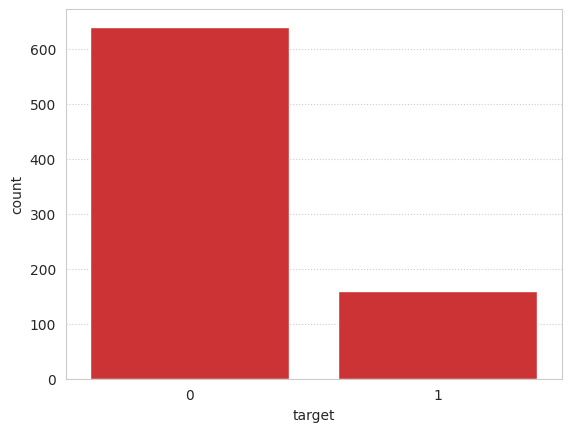

In [4]:
sns.countplot(x='target', data=df)

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

def preprocess(text):
    # Remove pontuação e coloca em minúsculo
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df["frase"] = df["frase"].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Parâmetros
vocab_size = 10000
max_length = 50
oov_token = "<OOV>"

# Tokenizador
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df["frase"])

# Transforma os textos em sequências numéricas
sequences = tokenizer.texts_to_sequences(df["frase"])

# Aplica padding para uniformizar o comprimento
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# X e y prontos para treinar
X = padded_sequences
y = df["target"].values

In [7]:
# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [8]:
y_train.shape, y_test.shape

((560,), (240,))

In [9]:
values, counts = np.unique(y_train, return_counts=True)
for v, c in zip(values, counts):
    print(f"{v}: {c}")

0: 448
1: 112


In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Perform random sampling
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [11]:
values, counts = np.unique(y_resampled, return_counts=True)
for v, c in zip(values, counts):
    print(f"{v}: {c}")

0: 448
1: 448


In [12]:
# Modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelo LSTM - smote
model_smote = Sequential()
model_smote.add(Embedding(input_dim=vocab_size, output_dim=64))
model_smote.add(LSTM(64, return_sequences=False))
model_smote.add(Dense(1, activation='sigmoid'))

model_smote.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# Treinamento
model.fit(X_resampled, y_resampled, epochs=10, validation_data=(X_test, y_test), batch_size=16)
model_smote.fit(X_train_smote, y_train_smote, epochs=10, validation_data=(X_test, y_test), batch_size=16)

# Avaliação
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

loss_smote, acc_smote = model_smote.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc_smote:.2f}")

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.4815 - loss: 0.6950 - val_accuracy: 0.8000 - val_loss: 0.6773
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5213 - loss: 0.6922 - val_accuracy: 0.2000 - val_loss: 0.7046
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5112 - loss: 0.6933 - val_accuracy: 0.8000 - val_loss: 0.6918
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.4765 - loss: 0.6936 - val_accuracy: 0.8000 - val_loss: 0.6878
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.4713 - loss: 0.6938 - val_accuracy: 0.8000 - val_loss: 0.6920
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.5032 - loss: 0.6932 - val_accuracy: 0.8000 - val_loss: 0.6910
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5190 - loss: 0.6931 - val_accuracy: 0.8000 - val_loss: 0.6892
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4819 - loss: 0.6933 - val_accuracy: 0.2000 -

In [14]:
y_test

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
y_pred_proba = model.predict(X_test).flatten()
y_pred_proba_smote = model_smote.predict(X_test).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [16]:
results = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_proba, 'y_pred_proba_smote': y_pred_proba_smote})
results

,y_test,y_pred_proba,y_pred_proba_smote
0,0,0.014022,0.129249
1,0,0.014022,0.129250
2,0,0.014022,0.129249
3,1,0.999181,0.988728
4,0,0.014022,0.129250
...,...,...,...
235,0,0.014022,0.129249
236,0,0.014022,0.129249
237,0,0.014022,0.988727
238,0,0.014022,0.129250


In [17]:
from scipy import stats
ks,p_value = stats.ks_2samp(results[results['y_test'] == 0]['y_pred_proba'],
                                results[results['y_test'] == 1]['y_pred_proba'], alternative='two-sided')
print("ks test:", ks, "\np_value", p_value)

from scipy import stats
ks_smote,p_value_smote = stats.ks_2samp(results[results['y_test'] == 0]['y_pred_proba_smote'],
                                results[results['y_test'] == 1]['y_pred_proba_smote'], alternative='two-sided')
print("ks test:", ks_smote, "\np_value", p_value_smote)

ks test: 0.9166666666666666 
p_value 1.5225655769688997e-36
ks test: 0.96875 
p_value 5.64330981509203e-44


In [18]:
### calculo score
def calculate_score(y_pred_proba, cte=200):
  p = y_pred_proba
  cond = True
  count = 0
  while cond:
    result_lg = [(cte*i)/((cte*i)+(1-i)) for i in p]
    media = np.mean(result_lg)
    mediana = np.median(result_lg)
    if (media<0.56) and (media>0.46):
      cond = False
    print('\nConstante: {}, Média: {}, Mediana: {} \r'.format(cte, media, mediana))
    cte = cte/2
    count += 1
    if count == 10:
      break

  return result_lg

In [19]:
results['score'] = calculate_score(y_pred_proba, cte=270)


Constante: 270, Média: 0.8312610983848572, Mediana: 0.7933816313743591 

Constante: 135.0, Média: 0.7203108668327332, Mediana: 0.657524824142456 

Constante: 67.5, Média: 0.5833225846290588, Mediana: 0.4897855222225189 

Constante: 33.75, Média: 0.4481862485408783, Mediana: 0.32431522011756897 

Constante: 16.875, Média: 0.34138360619544983, Mediana: 0.19354188442230225 

Constante: 8.4375, Média: 0.2708123028278351, Mediana: 0.10713887959718704 

Constante: 4.21875, Média: 0.22952228784561157, Mediana: 0.05660155043005943 

Constante: 2.109375, Média: 0.20704752206802368, Mediana: 0.029125036671757698 

Constante: 1.0546875, Média: 0.19525934755802155, Mediana: 0.014777718111872673 

Constante: 0.52734375, Média: 0.1891278773546219, Mediana: 0.00744386063888669 


In [20]:
results['score_smote'] = calculate_score(y_pred_proba_smote, cte=360)


Constante: 360, Média: 0.9852213263511658, Mediana: 0.9816299080848694 

Constante: 180.0, Média: 0.9709753394126892, Mediana: 0.9639225602149963 

Constante: 90.0, Média: 0.9439712762832642, Mediana: 0.9303576946258545 

Constante: 45.0, Média: 0.8952349424362183, Mediana: 0.869783878326416 

Constante: 22.5, Média: 0.8145992755889893, Mediana: 0.7695730328559875 

Constante: 11.25, Média: 0.6986029148101807, Mediana: 0.6254520416259766 

Constante: 5.625, Média: 0.5613523721694946, Mediana: 0.45502379536628723 

Constante: 2.8125, Média: 0.43188464641571045, Mediana: 0.2945183217525482 

Constante: 1.40625, Média: 0.3331294357776642, Mediana: 0.17268922924995422 

Constante: 0.703125, Média: 0.2687060534954071, Mediana: 0.09450457245111465 


In [21]:
results.head()

,y_test,y_pred_proba,y_pred_proba_smote,score,score_smote
0,0,0.014022,0.129249,0.007444,0.094505
1,0,0.014022,0.129250,0.007444,0.094505
2,0,0.014022,0.129249,0.007444,0.094505
3,1,0.999181,0.988728,0.998447,0.984044
4,0,0.014022,0.129250,0.007444,0.094505


In [22]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression()),
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier()),
    ]),
}



param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear'],
        'classifier__max_iter': [50, 100, 500]

    },
    'XGBoost': {
        'classifier__n_estimators': [30, 50],
        'classifier__max_depth': [2, 3],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.5, 0.7, 1]
    },
}


models = ['LogisticRegression']

In [23]:
for model in models:
  print(f"Evaluating {model}:")

  pipeline = pipelines[model]

  # grid search with cross validation
  grid_search = GridSearchCV(pipeline, param_grids[model], cv=5, error_score='raise')
  grid_search.fit(X_train_smote, y_train_smote)

  # evatuating the test set
  y_pred = grid_search.predict(X_test)
  y_pred_proba = grid_search.predict_proba(X_test)[:,1]
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f"Best Parameters: {grid_search.best_params_}")
  print(f"Accuracy: {accuracy}")
  print("Classification Report:\n", report)
  print("Confusion Matrix:\n", conf_matrix)
  print("-"*30)
  print("\n")

Evaluating LogisticRegression:
Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': 50, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Accuracy: 0.9416666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       192
           1       0.79      0.96      0.87        48

    accuracy                           0.94       240
   macro avg       0.89      0.95      0.92       240
weighted avg       0.95      0.94      0.94       240

Confusion Matrix:
 [[180  12]
 [  2  46]]
------------------------------




In [24]:
results2 = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_proba})
results2

,y_test,y_pred_proba
0,0,0.014257
1,0,0.345175
2,0,0.073227
3,1,0.883424
4,0,0.021090
...,...,...
235,0,0.031007
236,0,0.035299
237,0,0.866204
238,0,0.659703


In [25]:
from scipy import stats
ks2,p_value2 = stats.ks_2samp(results2[results2['y_test'] == 0]['y_pred_proba'],
                                results2[results2['y_test'] == 1]['y_pred_proba'], alternative='two-sided')
print("ks test:", ks2, "\np_value", p_value2)

ks test: 0.8958333333333334 
p_value 3.4645383537451046e-34


In [26]:
results2['score'] = calculate_score(y_pred_proba, cte=360)


Constante: 360, Média: 0.924942751419334, Mediana: 0.9509508917747116 

Constante: 180.0, Média: 0.8696671030451505, Mediana: 0.9064892629440695 

Constante: 90.0, Média: 0.7906096234804473, Mediana: 0.8289739183748326 

Constante: 45.0, Média: 0.6923304716515063, Mediana: 0.7079093425846634 

Constante: 22.5, Média: 0.5863435932901098, Mediana: 0.5478876384004973 

Constante: 11.25, Média: 0.48597486205834994, Mediana: 0.3773126166981237 


In [27]:
from pandas import qcut as qcut

def make_analysis_table(resp, score,n=20):
  df = pd.DataFrame(data = {'resp':resp, 'score':score})
  df['y_pred_g'] = qcut(df.score + np.random.uniform(low=-0.00001,
                                                     high=0.00001,
                                                     size=df['score'].shape[0]),
                        q=n,
                        labels = range(n))
  tabelao = df.groupby(['y_pred_g'], as_index=False).agg({'score':['min', 'max'],
                                                          'resp':['size','sum']})
  tabelao.columns = ['quebras','score_min','score_max','total','total_maus']
  tabelao['total_bons'] = tabelao['total'] - tabelao['total_maus']
  tabelao['tx_maus'] = tabelao['total_maus']/tabelao['total']
  tabelao['tx_bons'] = tabelao['total_bons']/tabelao['total']
  tabelao['p_maus'] = tabelao['total_maus']/tabelao['total_maus'].sum()
  tabelao['p_bons'] = tabelao['total_bons']/tabelao['total_bons'].sum()
  tabelao['p_maus_acum'] = np.cumsum(tabelao['p_maus'][::-1])[::-1]
  tabelao['p_bons_acum'] = np.cumsum(tabelao['p_bons'][::-1])[::-1]
  tabelao['exposicao'] = tabelao.total_maus / tabelao.total

  return tabelao

In [28]:
tabelao = make_analysis_table(results['y_test'].values,results['score'].values)
tabelao

<ipython-input-27-613117d7a1f6>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabelao = df.groupby(['y_pred_g'], as_index=False).agg({'score':['min', 'max'],


,quebras,score_min,score_max,total,total_maus,total_bons,tx_maus,tx_bons,p_maus,p_bons,p_maus_acum,p_bons_acum,exposicao
0,0,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,1.000000,0.000000
1,1,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.937500,0.000000
2,2,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.875000,0.000000
3,3,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.812500,0.000000
4,4,0.007444,0.007444,12,2,10,0.166667,0.833333,0.041667,0.052083,1.000000,0.750000,0.166667
5,5,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,0.958333,0.697917,0.000000
6,6,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,0.958333,0.635417,0.000000
7,7,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,0.958333,0.572917,0.000000
8,8,0.007444,0.007444,12,1,11,0.083333,0.916667,0.020833,0.057292,0.958333,0.510417,0.083333
9,9,0.007444,0.007444,12,0,12,0.000000,1.000000,0.000000,0.062500,0.937500,0.453125,0.000000


In [34]:
tabelao_smote = make_analysis_table(results['y_test'].values,results['score_smote'].values)
tabelao_smote

<ipython-input-27-613117d7a1f6>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabelao = df.groupby(['y_pred_g'], as_index=False).agg({'score':['min', 'max'],


,quebras,score_min,score_max,total,total_maus,total_bons,tx_maus,tx_bons,p_maus,p_bons,p_maus_acum,p_bons_acum,exposicao
0,0,0.094504,0.094505,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,1.000000,0.000000
1,1,0.094504,0.094505,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.937500,0.000000
2,2,0.094504,0.094506,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.875000,0.000000
3,3,0.094504,0.094505,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.812500,0.000000
4,4,0.094504,0.094505,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.750000,0.000000
5,5,0.094504,0.094505,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.687500,0.000000
6,6,0.094504,0.094506,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.625000,0.000000
7,7,0.094504,0.094506,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.562500,0.000000
8,8,0.094504,0.094505,12,1,11,0.083333,0.916667,0.020833,0.057292,1.000000,0.500000,0.083333
9,9,0.094504,0.094505,12,0,12,0.000000,1.000000,0.000000,0.062500,0.979167,0.442708,0.000000


In [29]:
def plot_p_maus_acum_with_affine(tabelao, ks=ks, title="Plot KS"):

    # extraindo dados pro plot
    p_maus_acum = tabelao['p_maus_acum'].values
    p_bons_acum = tabelao['p_bons_acum'].values
    x = np.arange(len(p_maus_acum))  # Create x-axis values
    score_cuts = tabelao['quebras'].values

    # criando linha comparativa de aleatoriedade
    affine_line = np.linspace(1, 0, len(p_maus_acum))  # Line from 0 to 1

    # plotando grafico
    plt.figure(figsize=(8, 6))
    plt.plot(x, p_maus_acum, marker='o', label='P_maus_acum')
    plt.plot(x, p_bons_acum, marker='o', label='P_bons_acum')
    plt.plot(x, affine_line, linestyle='--', label='Reta de Aleatoriedade')

    # Add markers
    last_4_indices = tabelao.index[-4:]
    last_4_x = x[last_4_indices]
    last_4_y = p_maus_acum[last_4_indices]

    for i, j in zip(last_4_x, last_4_y):
        plt.text(i, j, f'{j*100:.2f}%', ha='center', va='top') # Format with 2 decimal places


    # Customizing the plot
    plt.title(f'{title} - KS Test {ks:.3f}')
    plt.xticks(x, score_cuts, rotation=45, ha='right')
    plt.ylabel('Probabilidade Acumulada de Maus')
    plt.legend()
    plt.grid(True)

    plt.show()


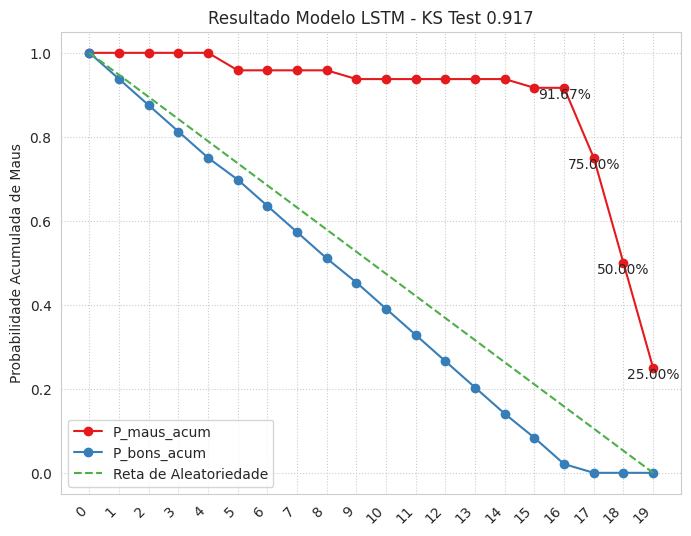

In [30]:
# Assuming 'tabelao' is your DataFrame from make_analysis_table
plot_p_maus_acum_with_affine(tabelao,ks, title='Resultado Modelo LSTM')

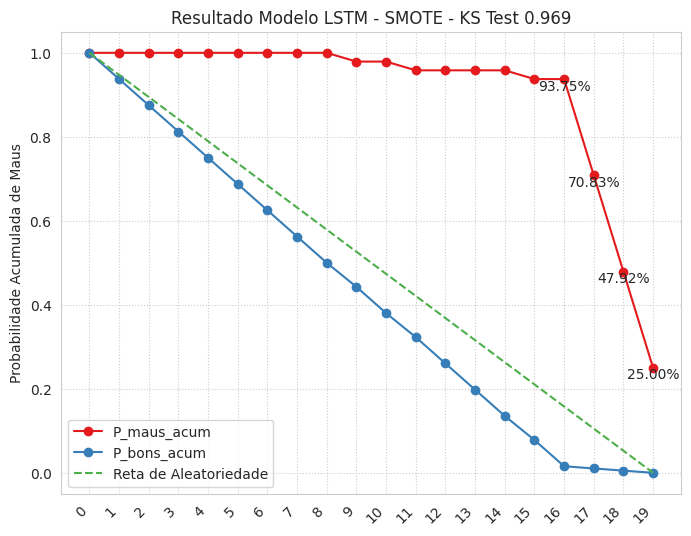

In [35]:
plot_p_maus_acum_with_affine(tabelao_smote,ks_smote, title='Resultado Modelo LSTM - SMOTE')

In [31]:
tabelao2 = make_analysis_table(results2['y_test'].values,results2['score'].values)
tabelao2

<ipython-input-27-613117d7a1f6>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabelao = df.groupby(['y_pred_g'], as_index=False).agg({'score':['min', 'max'],


,quebras,score_min,score_max,total,total_maus,total_bons,tx_maus,tx_bons,p_maus,p_bons,p_maus_acum,p_bons_acum,exposicao
0,0,0.069636,0.091398,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,1.000000,0.000000
1,1,0.096870,0.125617,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.937500,0.000000
2,2,0.129577,0.129838,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.875000,0.000000
3,3,0.130459,0.139943,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.812500,0.000000
4,4,0.139943,0.186994,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.750000,0.000000
5,5,0.186994,0.225008,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.687500,0.000000
6,6,0.251027,0.264701,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.625000,0.000000
7,7,0.265465,0.281274,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.562500,0.000000
8,8,0.281274,0.305884,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.500000,0.000000
9,9,0.305884,0.373845,12,0,12,0.000000,1.000000,0.000000,0.062500,1.000000,0.437500,0.000000


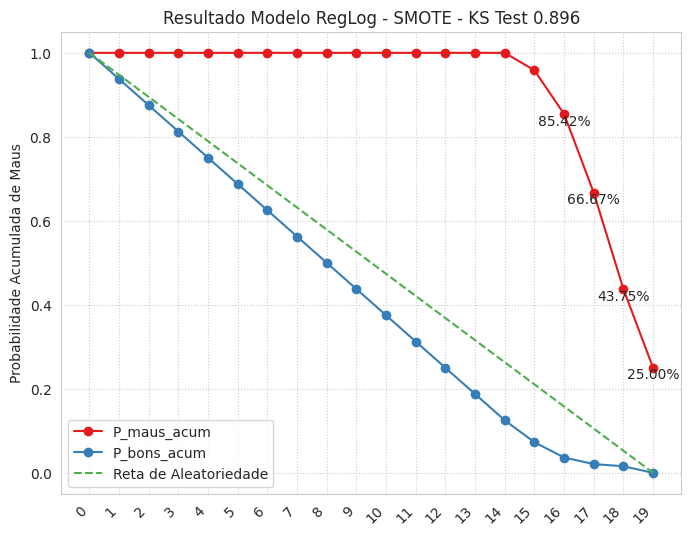

In [36]:
plot_p_maus_acum_with_affine(tabelao2,ks2,title="Resultado Modelo RegLog - SMOTE")

In [37]:
tabelao2.to_excel('tabelao_result_reglog_smote.xlsx')